# Dimensionality Reduction of Single-Cell Coculture Data
Morphological feature space is high-dimensional, often with hundreds of features. In order to explore the structure of the data, one can use dimensionality reduction methods to embed the single-cell data in lower dimensions (in 2D)

## DMSO Control Wells
We will start with DMSO control wells and we will also use these for feature standardization:

In [1]:
# load third-party Python modules
import javabridge
import bioformats as bf
import skimage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import re
import os
import sys
import h5py
import json
from sklearn.manifold import TSNE

javabridge.start_vm(class_path=bf.JARS)

Simple function for loading pre-computed morphological features:

In [2]:
def load_cells(platedir, wells, annot, which=[1,2]):
    imgdf = []
    for w in wells:
        df = pd.read_csv(os.path.join(platedir, w+'.csv'))
        imgdf.append(df[np.isin(df['class'], which)])
    imgdf = pd.concat(imgdf).reset_index(drop=True)
    labels = imgdf[['class', 'file']]
    imgdf = imgdf.drop(['class', 'file'], axis=1)
    labels['well'] = labels['file'].replace(regex=r'f[0-9].+', value='') 
    labels = pd.merge(labels, annot, on='well')
    return imgdf, labels

Choose a plate and load the plate map:

In [3]:
path = '/Volumes/gitlab/microscopy-notebooks/imgdata/'
path = '../data/imgdata/'
platedir = os.path.join(path, '180528_Plate5')
# load plate annotation
annot_df = pd.read_csv('../data/AML_trainset/drugannot.txt',
                      sep='\t')

Load only control wells:

In [4]:
dmso = annot_df[annot_df.Drug == 'DMSO'].reset_index(drop=True)
dmso_wells = dmso['well'].unique()

In [5]:
imgdf, labels = load_cells(platedir=platedir, wells=dmso_wells, annot=annot_df)

Map integer classes to their names:

In [6]:
labels['class'] = labels['class'].apply(lambda x: 'Viable' if x == 2 else 'Apoptotic')

## Load Feature Selection Dictionary
In `feature-selection.ipynb` we applied a number of methods to identify reproducible, non-redundant morphological features. Let's read in the feature sets:

In [7]:
with open('featselect.json') as file:
    featdict = json.load(file)
{k : len(v) for k,v in featdict.items()}

{'repcor': 166, 'residcor': 44, 'uncorr': 6}

+ `repcor` features: reproducible features with biological replicate correlation > 0.6
+ `residcor`: non-redundant feature set determined by correlation of regression residuals
+ `uncorr`: uncorrelated features by greedy search

A robust method of identifying non-redundant features is based on correlation of regression residuals: an initial feature set is used to fit linear models to predict all other features, the correlation between replicate residuals is computed and in each iteration a feature with the highest residual correlation is added into the feature set.

We will start by removing noisy features and subset the data only to `repcor` features:

In [8]:
from bioimg.singlecell import preprocess_data
sel = featdict['repcor']
imgdf = preprocess_data(df=imgdf, sel=sel, glog=True)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


Standardize data (center and scale):

In [9]:
from sklearn.preprocessing import StandardScaler
from bioimg.singlecell import scale_data, check_data
scaler = StandardScaler().fit(X=imgdf)
imgdf_scaled = scale_data(imgdf, scaler=scaler)

In [10]:
check_data(imgdf_scaled)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [11]:
def subset_ncells(imgdf, labels, n):
    subset = np.random.choice(imgdf.index, size=n)
    imgdf_s = imgdf.loc[subset,:].reset_index(drop=True)
    labels_s = labels.loc[subset,:].reset_index(drop=True)
    return imgdf_s, labels_s

Subset to $\approx$ 2000 cells to speed up embedding:

In [12]:
np.random.seed(2906)
imgdf_sub, labels_sub = subset_ncells(imgdf=imgdf_scaled, labels=labels, n=2000)

Run t-SNE on the first 20 principal components:

In [13]:
from sklearn.decomposition import PCA
pcs = PCA(n_components=20).fit_transform(imgdf_sub)
X_tsne = TSNE(n_components=2, random_state=21, perplexity=50).fit_transform(pcs)

In [14]:
X_df = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']), labels_sub], axis=1)

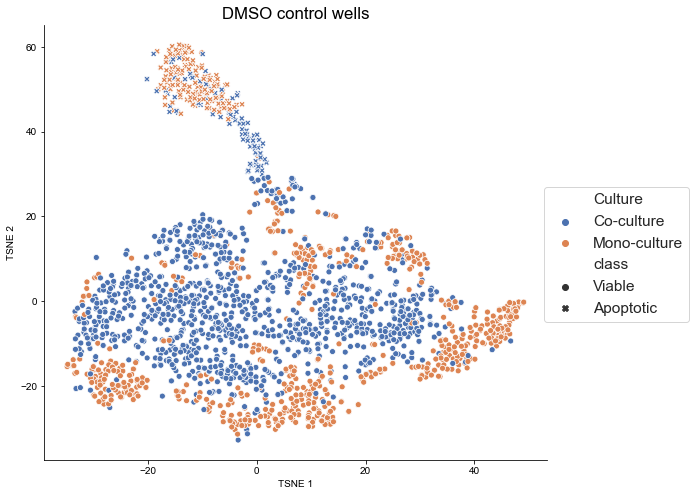

In [15]:
from bioimg.singlecell import plot_dimred
plot_dimred(X_df, 
            hue='Culture',
            style='class',
            title='DMSO control wells',
            style_order=['Viable', 'Apoptotic'])
plt.legend(loc='lower right',
           bbox_to_anchor=(1.3,0.3))
#plt.savefig('../figures/viab_and_apoptotic_tsne.pdf', bbox_inches='tight')

## Dimensionality reduction in viable leukemia cells
We are not interested in coculture-monoculture difference in apoptotic cell population. Load only viable cells from DMSO wells:

In [16]:
# which=2 selects only 'Viable' cancer cells
ctrl_df, ctrl_annot = load_cells(platedir=platedir, wells=dmso_wells, annot=annot_df, which=2)

In [17]:
ctrl_df = preprocess_data(df=ctrl_df, sel=sel, glog=True)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [18]:
scaler = StandardScaler().fit(X=ctrl_df)
ctrl_scaled = scale_data(ctrl_df, scaler=scaler)

In [19]:
X_subset = ctrl_scaled[featdict['residcor']]

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30).fit(X_subset)

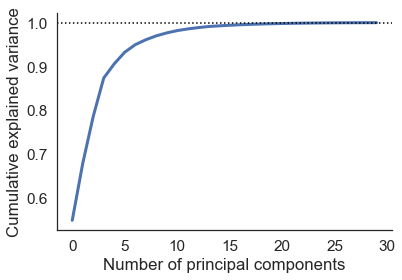

In [21]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=3)
sn.despine()
plt.axhline(y=1, color='black', linestyle=':')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance');

Run t-SNE on the first 15 principal components:

In [22]:
pcs = PCA(n_components=15).fit_transform(X_subset)
X_tsne = TSNE(n_components=2, random_state=34, perplexity=30).fit_transform(pcs)

In [23]:
X_ctrl = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']),
                    ctrl_annot], axis=1)

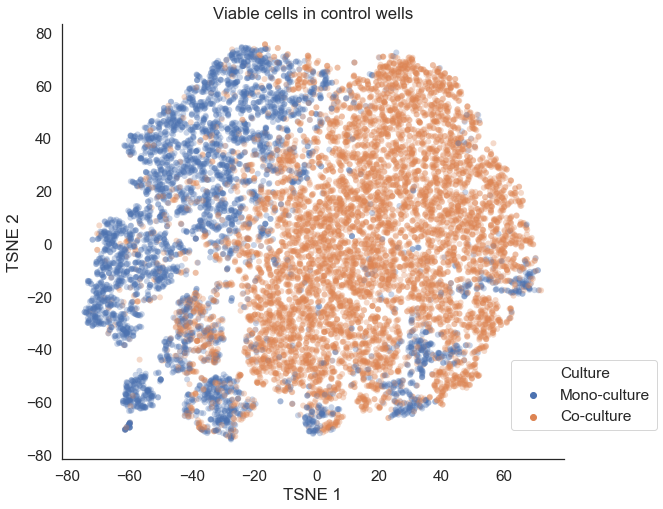

In [24]:
plot_dimred(X_ctrl, hue='Culture',
           title='Viable cells in control wells', linewidth=0, alpha=0.3)
plt.legend(loc='lower right',
           bbox_to_anchor=(1.2,0.05))

In [25]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def cm2inch(tup):
    inch = 2.54
    return tuple([t/2.54 for t in tup])

"plt.savefig('../figures/TSNE-AML218-controls.png',\n           bbox_inches='tight',\n           dpi=600)"

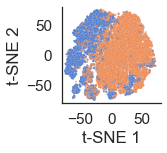

In [26]:
fig, ax = plot_dimred(X_ctrl, hue='Culture',
           title='',
           size=cm2inch((4.5,4.5)),
           palette = sn.color_palette(['#4878d0', '#ee854a']),
           alpha=0.5, s = 5, linewidth=0.1)
ax.set(xlim=(-80,80), ylim=(-80,80), yticks=[-50,0,50])
ax.get_legend().remove()
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')

    
sn.set(font='Helvetica', style='white')
sn.set(style='white')
sn.set_context("paper", rc={"font.size": 7,
                            "axes.titlesize": 9,
                            "xtick.labelsize": 7,
                            "ytick.labelsize" : 7,
                            "axes.labelsize": 9})   
'''plt.savefig('../figures/TSNE-AML218-controls.png',
           bbox_inches='tight',
           dpi=600)'''

(0.0, 1.0, 0.0, 1.0)

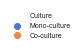

In [27]:
fig_leg = plt.figure(figsize=cm2inch((3,1.5)))
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(),
              #ncol = 2,
              loc='upper center',
              frameon=False,
              fontsize = 7, columnspacing = 1.3)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
#fig_leg.savefig('../figures/tsne-coculture-legend.pdf')

## Identifying top features distinguishing coculture from monoculture

Use recursive feature elimination (RFE) to identify top 9 features that separate leukemia cells in coculture from those in monoculture:

In [28]:
from bioimg.singlecell import recursive_elim, select_features

y=np.copy(ctrl_annot['Culture'].values)
y[y=='Mono-culture'] = 0
y[y=='Co-culture'] = 1
y = y.astype(int)

rfe = recursive_elim(df=X_subset, y=y, n_feat=9, elim_step=1)
X_rfe = select_features(df=X_subset, sel=rfe)
feat_subset = X_rfe.columns.values

Top 9 features that differentiate coculture from monoculture cancer cells are:

In [29]:
feat_subset

array(['ch-Lysosomal-area', 'ch-Lysosomal-SumAverage-d7-3',
       'ch-Hoechst-SumAverage-d3-0', 'ch-Calcein-moments_central-2-2',
       'ch-Hoechst-InfoMeas1-d5-3',
       'ch-Calcein-weighted_moments_central-2-2',
       'ch-Lysosomal-InfoMeas1-d7-0', 'ch-Calcein-convex_area',
       'ch-Lysosomal-Contrast-d7-1'], dtype=object)

Some of these features are difficult to interpret. However, looking at the correlation heatmap we see that
+ `ch-Calcein-moments_hu-1` is highly correlated with and can be replaced by `Calcein-eccentricity`
+ `ch-Calcein-moments_central-2-2` can be replaced by `Calcein-convex_area`
+ `ch-Lysosomal-InfoMeas2-d5-0` can be replaced by `ch-Lysosomal-mean_intensity`

In [30]:
#feat_subset[feat_subset == 'ch-Calcein-moments_hu-1'] = 'ch-Calcein-eccentricity'
#feat_subset[feat_subset == 'ch-Calcein-moments_central-2-2'] = 'ch-Calcein-convex_area'
#feat_subset[feat_subset == 'ch-Lysosomal-InfoMeas2-d5-0'] = 'ch-Lysosomal-mean_intensity'

In [31]:
X_ctrl = pd.concat([X_ctrl, ctrl_scaled.loc[:,feat_subset]], axis=1)

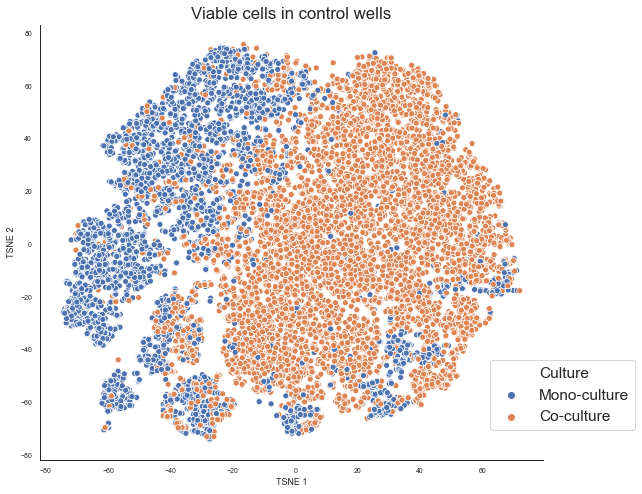

In [32]:
plot_dimred(X_ctrl, hue='Culture',
           title='Viable cells in control wells')
plt.legend(loc='lower right',
           bbox_to_anchor=(1.2,0.05))
#plt.savefig('../figures/DMSO_viable.pdf', bbox_inches='tight')

In [33]:
X_ctrl.loc[X_ctrl['ch-Lysosomal-area'] < -2,'ch-Lysosomal-area'] = -2

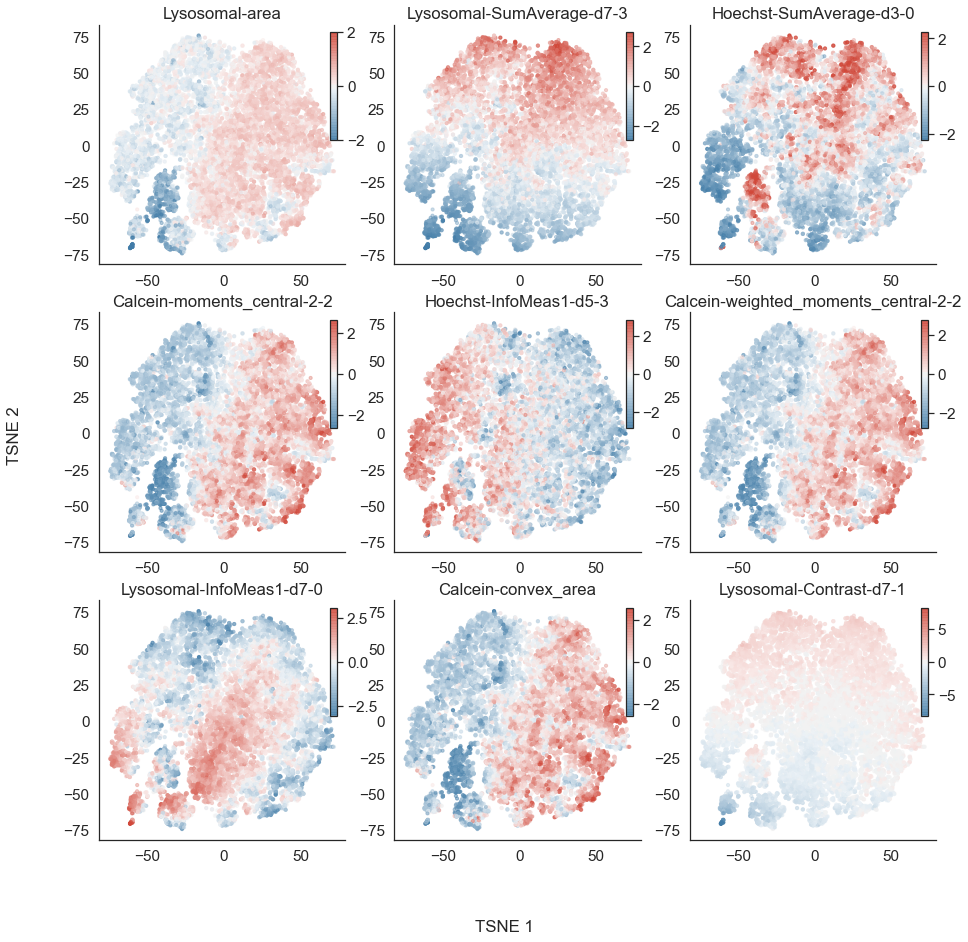

In [34]:
from bioimg.singlecell import facet_dimred
facet_dimred(X_ctrl, feat_subset=feat_subset,
            nrows=3, ncols=3)
#plt.savefig('../figures/DMSO-viab-wiht-feats.pdf', bbox_inches='tight')

In [35]:
colsub = ['Culture'] + feat_subset.tolist()
X_long = pd.melt(X_ctrl[colsub], 
                 id_vars=['Culture'], 
                 value_vars=feat_subset,
                 var_name='feature', 
                 value_name='val')

<Figure size 720x576 with 0 Axes>

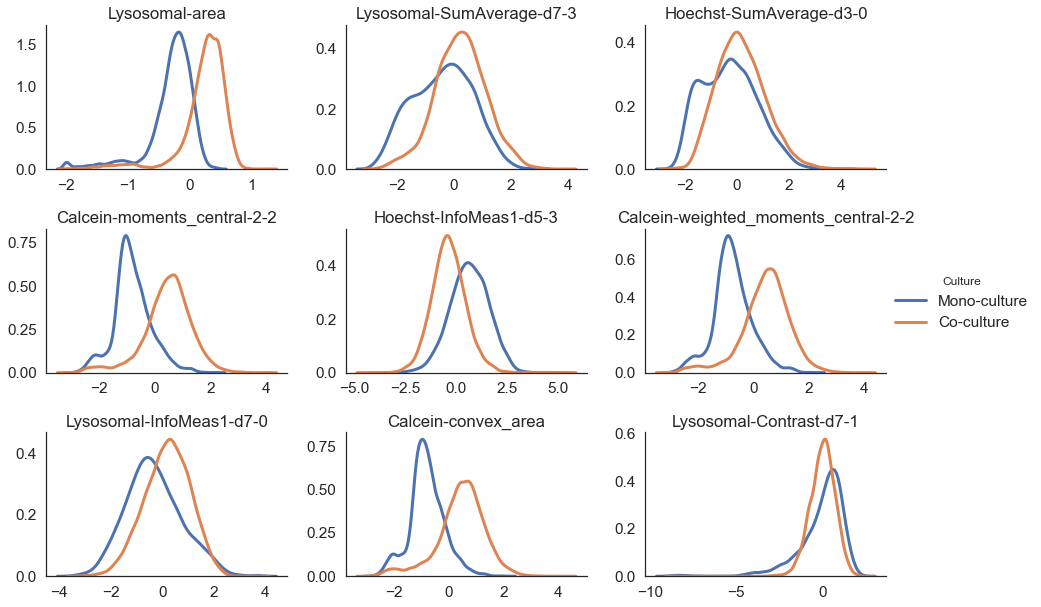

In [36]:
from bioimg.singlecell import facet_density
facet_density(X_long, feat_column='feature',
             ncols=3, hue='Culture',
             sharey=False, size=(10,8),
             aspect=1.4)
#plt.savefig('../figures/facet_density.pdf', bbox_inches='tight')

Make a plot for the paper:

In [37]:
from bioimg.singlecell import facet_dimred

In [38]:
# which=2 selects only 'Viable' cancer cells
ctrl_df, ctrl_annot = load_cells(platedir=platedir, 
                                 wells=dmso_wells,
                                 annot=annot_df, which=2)
ctrl_df = preprocess_data(df=ctrl_df, sel=sel, glog=True)
scaler = StandardScaler().fit(X=ctrl_df)
ctrl_scaled = scale_data(ctrl_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


"plt.savefig('../figures/TSNE-AML218-controls-by-feature.pdf',\n           bbox_inches='tight')"

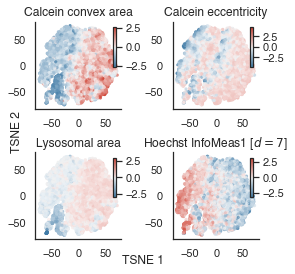

In [39]:
feat_subset_small = ['ch-Calcein-convex_area',
               'ch-Calcein-eccentricity',
               'ch-Lysosomal-area',
               'ch-Hoechst-InfoMeas1-d7-3']
X_ctrl = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']),
                    ctrl_annot], axis=1)
X_ctrl = pd.concat([X_ctrl, ctrl_scaled.loc[:,feat_subset_small]], axis=1)
X_ctrl.loc[X_ctrl['ch-Lysosomal-area'] < -3,'ch-Lysosomal-area'] = -3
cols = [c.replace('ch-', '') for c in X_ctrl.columns] 
cols = [c.replace('d7-3', '[$d=7$]') for c in cols] 
cols = [c.replace('-', ' ') for c in cols]
cols = [c.replace('_', ' ') for c in cols]
X_ctrl.columns = cols
sn.set(font='Helvetica', style='white')
facet_dimred(X_ctrl, feat_subset=cols[8:],
            nrows=2, ncols=2, scale=2, s=5)
sn.set_context("paper", rc={"font.size": 9,
                            "axes.titlesize": 9,
                            "axes.labelsize": 7}) 
plt.subplots_adjust(wspace=0.6, hspace=0.5)
'''plt.savefig('../figures/TSNE-AML218-controls-by-feature.pdf',
           bbox_inches='tight')'''

Embed using UMAP:

In [40]:
'''import umap
X_umap = umap.UMAP(random_state=29,
                   n_neighbors=30,
                   min_dist=0.2,
                   metric='correlation').fit_transform(pcs)
X_ctrl = pd.concat([pd.DataFrame(X_umap, columns=['umap1', 'umap2']), ctrl_annot], axis=1)
plot_dimred(X_ctrl, dims='umap', hue='Culture',
           title='Viable cells in control wells')
plt.legend(loc='lower right',
           bbox_to_anchor=(1.2,0.05))'''

"import umap\nX_umap = umap.UMAP(random_state=29,\n                   n_neighbors=30,\n                   min_dist=0.2,\n                   metric='correlation').fit_transform(pcs)\nX_ctrl = pd.concat([pd.DataFrame(X_umap, columns=['umap1', 'umap2']), ctrl_annot], axis=1)\nplot_dimred(X_ctrl, dims='umap', hue='Culture',\n           title='Viable cells in control wells')\nplt.legend(loc='lower right',\n           bbox_to_anchor=(1.2,0.05))"

## Dimensionality Reduction on Drug Wells

Now load some drug wells:

In [41]:
drug_sel = ['Tofacitinib', 'Midostaurin',
                   'Ganetespib', 'Lenalidomide',
                   'Pyridone 6', 'UMI-77',
                   'Bafilomycin A1', 
                   'Quizartinib', 'Hydroxychloroquine',
                   'Fludarabine', 'Vorinostat',
                   'Thioguanine', 'Nutlin 3a',
                   'Palbociclib', 'Carfilzomib',
                   'JQ1', 'Cytarabine',
                   'BAY61-3606', 'Venetoclax',
                   'Ixazomib']

In [42]:
drugs = annot_df[np.isin(annot_df.Drug, drug_sel) ].reset_index(drop=True)
drug_wells = drugs['well'].unique()

In [43]:
# which=2 selects only 'Viable' cancer cells
drug_df, drug_annot = load_cells(platedir=platedir, wells=drug_wells, annot=annot_df, which=2)

In [44]:
drug_df = preprocess_data(df=drug_df, sel=sel, glog=True)
# scale by control wells
drug_scaled = scale_data(drug_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [45]:
pcs = PCA(n_components=15).fit_transform(drug_scaled[featdict['residcor']])
X_tsne = TSNE(n_components=2, random_state=21, perplexity=50).fit_transform(pcs)

In [46]:
X_df = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']), drug_annot], axis=1)
X_df = pd.concat([X_df, drug_scaled.loc[:,feat_subset]], axis=1)
#X_df = pd.concat([X_df, Xfeat], axis=1)

(<Figure size 648x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Viable cells in drug-treated wells'}, xlabel='TSNE 1', ylabel='TSNE 2'>)

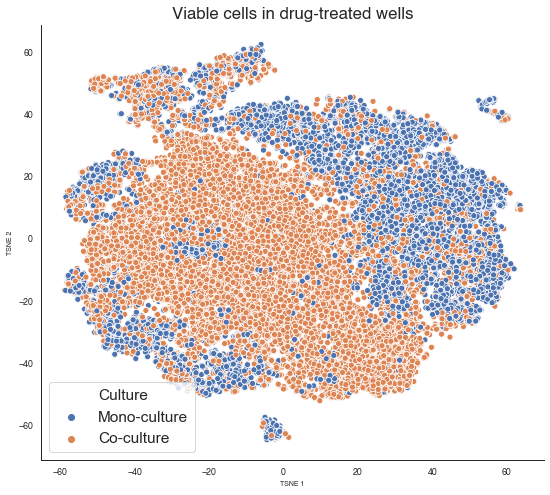

In [47]:
plot_dimred(X_df, hue='Culture',
           title='Viable cells in drug-treated wells')

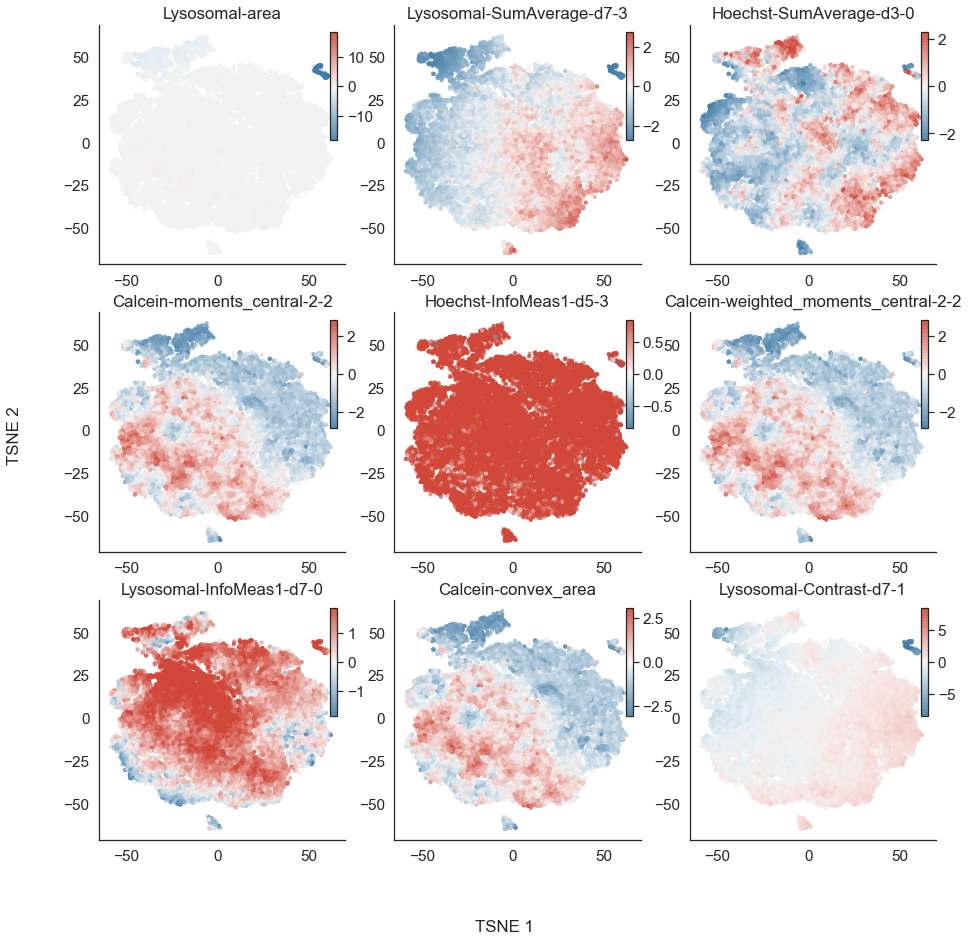

In [49]:
facet_dimred(X_df, feat_subset=feat_subset,
            nrows=3, ncols=3)

In [50]:
colsub = ['Culture'] + feat_subset.tolist()
X_long = pd.melt(X_df[colsub], 
                 id_vars=['Culture'], 
                 value_vars=feat_subset,
                 var_name='feature', 
                 value_name='val')

<Figure size 720x720 with 0 Axes>

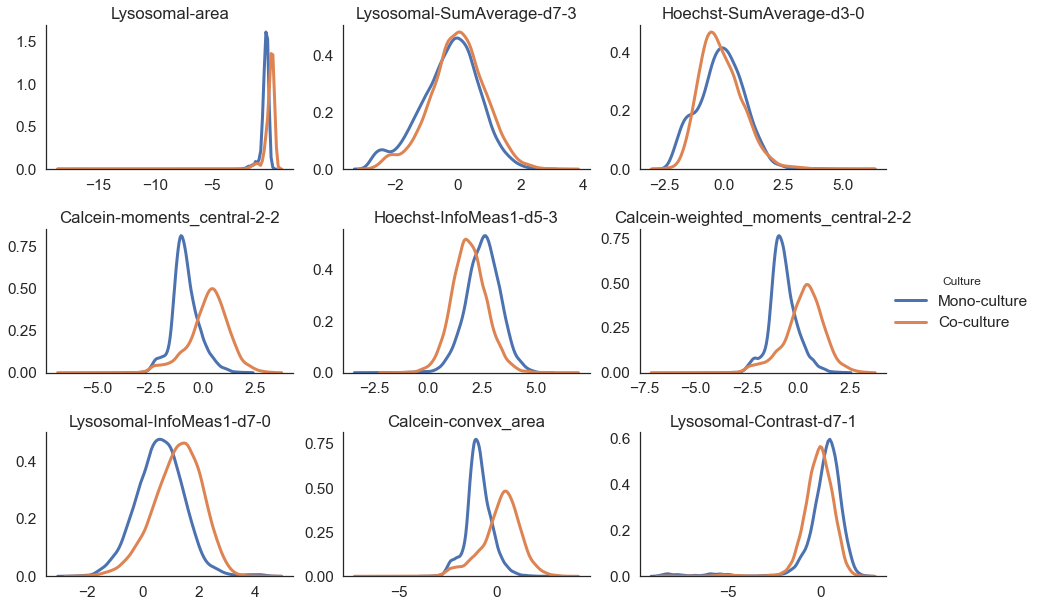

In [51]:
from bioimg.singlecell import facet_density
facet_density(X_long, feat_column='feature',
             ncols=3, hue='Culture', sharey=False,
             aspect=1.4)

In [52]:
colsub = ['Drug', 'Culture'] + feat_subset.tolist()
X_long = pd.melt(X_df[colsub], 
                 id_vars=['Drug', 'Culture'], 
                 value_vars=feat_subset,
                 var_name='feature', 
                 value_name='val')

In [53]:
drug_subset = ['Tofacitinib', 'Midostaurin',
                   'Ganetespib', 'Lenalidomide',
                   'Pyridone 6', 'UMI-77',
                   'Bafilomycin A1', 
                   'Fludarabine', 'Vorinostat',
                   'Palbociclib', 'Carfilzomib',
                   'JQ1', 'BAY61-3606', 'Venetoclax',
                   'Ixazomib']
fsub = ['ch-Hoechst-mean_intensity', 'ch-Lysosomal-mean_intensity',
        'ch-Calcein-convex_area', 'ch-Calcein-eccentricity',
        'ch-Lysosomal-Contrast-d7-3', 'ch-Hoechst-InfoMeas1-d7-3']
X_long = X_long.loc[np.isin(X_long['Drug'], drug_subset),:]
X_long = X_long.loc[np.isin(X_long['feature'], fsub),:]

<Figure size 720x720 with 0 Axes>

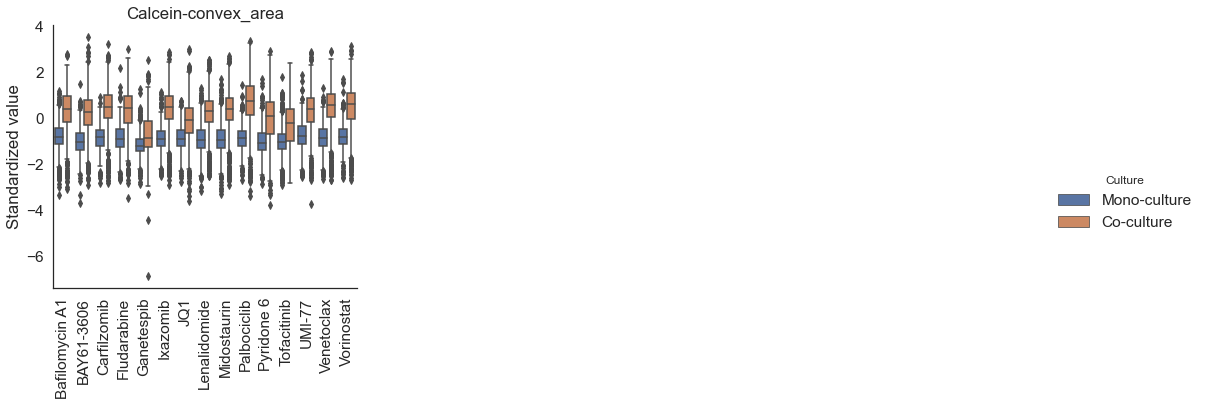

In [54]:
from bioimg.singlecell import facet_boxplot
facet_boxplot(X_long, x='Drug',
              y='val', feat_column='feature',
              ncols=3,
              nrows=2, hue='Culture')
#plt.savefig('../figures/drug-boxplots.pdf', bbox_inches='tight')

In [55]:
drug_chunks = [drug_sel[i:i + 5] for i in range(0, len(drug_sel), 5)]

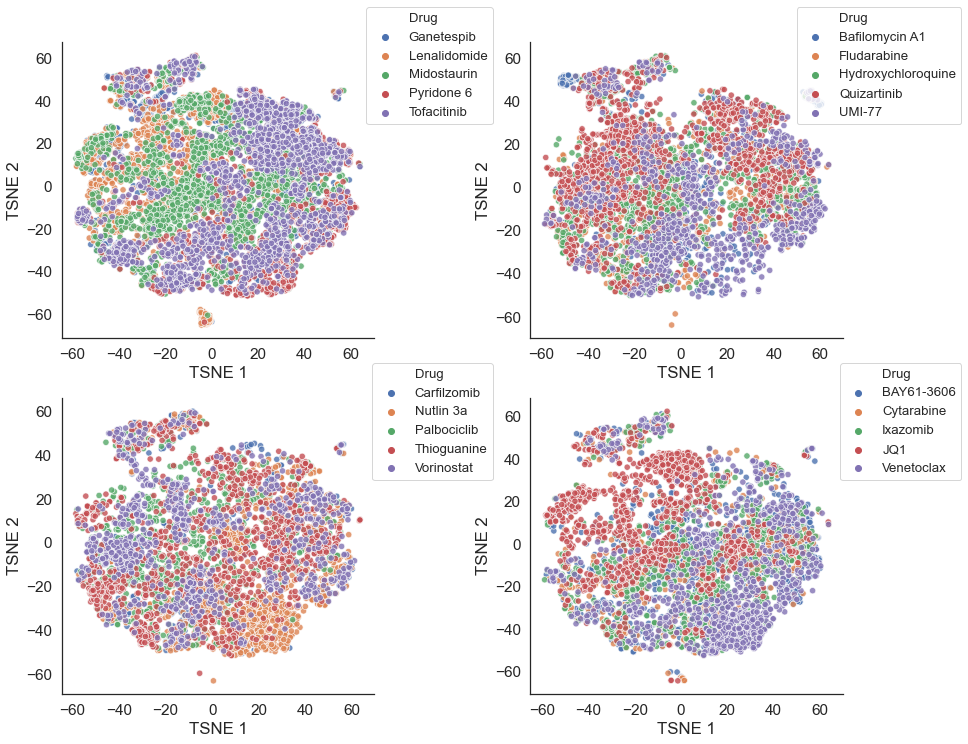

In [56]:
fig, ax = plt.subplots(ncols=2, nrows=2,
                       figsize = (14,12))
sn.set(font_scale=1.2)
sn.set_style('white')
sn.despine()
for r in range(2):
    for c in range(2):
        sn.scatterplot(x = 'tsne1', y = 'tsne2', data=X_df[np.isin(X_df['Drug'], drug_chunks[r*2+c])],
               hue = 'Drug',
               s = 40, alpha = 0.8, ax=ax[r,c])
        ax[r,c].legend(loc='lower right', bbox_to_anchor=(1.4,0.7))
        ax[r,c].set_xlabel('TSNE 1')
        ax[r,c].set_ylabel('TSNE 2')
fig.subplots_adjust(wspace=0.5)